# Imports

## Libraries

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest, proportions_chisquare
from scipy.stats import zscore, chisquare, chi2_contingency

from sklearn.preprocessing import OneHotEncoder

## Data

In [2]:
PATH = "../Data/"

In [3]:
DF = pd.read_csv(PATH + "bodyPerformance.csv")

In [4]:
DF.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


# EDA

## Age Distribution

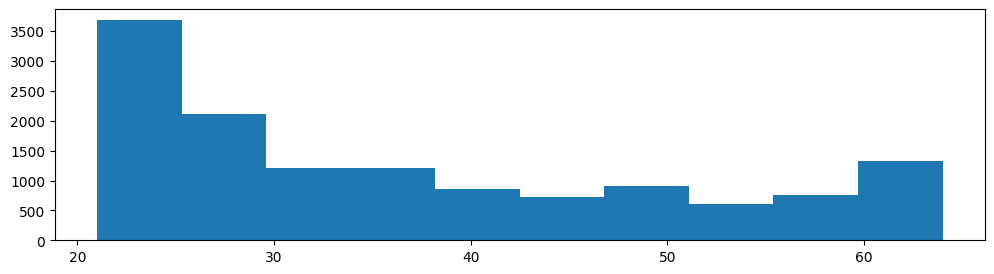

In [5]:
DF["age"].hist(grid=False, figsize=(12,3));

## Gender Distribution

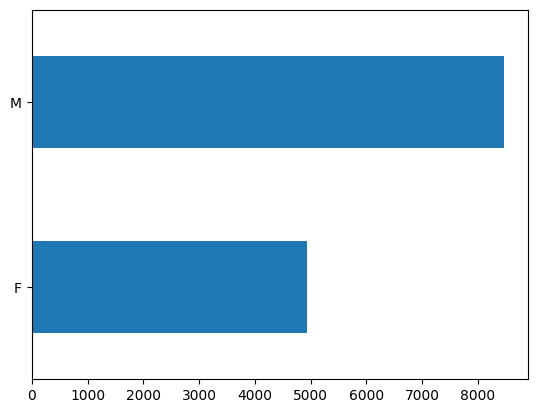

In [6]:
DF["gender"].value_counts()[::-1].plot(kind="barh", ylabel="");

In [7]:
DF["class"].value_counts()

class
C    3349
D    3349
A    3348
B    3347
Name: count, dtype: int64

## Height to Weight distribution

### By Gender

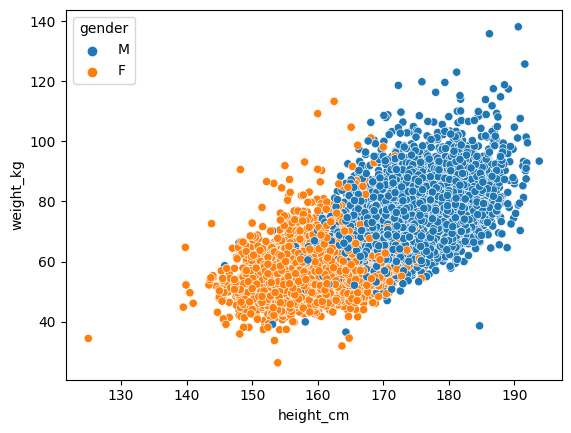

In [8]:
sns.scatterplot(DF, x="height_cm", y="weight_kg", hue="gender");

### By Class

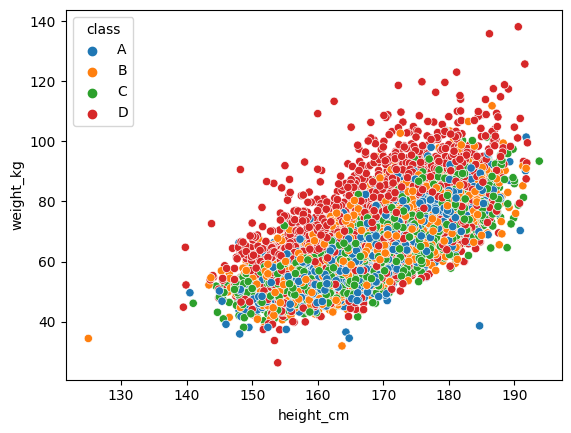

In [9]:
sns.scatterplot(DF, x="height_cm", y="weight_kg", hue="class", hue_order=["A", "B", "C", "D"]);

# Feature Engineering

In [10]:
def bmi_calculator(height, weight):
    """
    height: float height in cm
    weight: float weight in kg
    """

    height_in_m = height/100
    bmi = round(weight / (height_in_m**2),2)

    return bmi

In [11]:
def blood_pressure_cat(diastolic, systolic):
    """
    diastolic: float
    systolic: float
    """
    
    if systolic <= 90 and diastolic <= 60:
        return "Hypotension"
    elif systolic <= 120 and diastolic <= 80:
        return "Normal"
    elif systolic <= 130 and diastolic <= 80:
        return "Elevated"
    elif systolic <= 140 and diastolic <= 90:
        return "Stage 1"
    elif systolic <= 180 and diastolic <= 100:
        return "Stage 2"
    elif systolic > 100 and diastolic > 80:
        return "Hypertensive Crisis"
    else:
        return np.nan

In [12]:
DF["Blood_Pressure_Cat"] = DF.apply(lambda row: blood_pressure_cat(row["diastolic"], row["systolic"]), axis=1)

In [13]:
DF["BMI"] = bmi_calculator(DF["height_cm"], DF["weight_kg"])

In [14]:
DF["BMI_Class"] = \
pd.cut(bmi_calculator(DF["height_cm"], DF["weight_kg"])
       ,bins=[0, 18.5, 25, 30, 40]
       ,labels=["Underweight", "Healthy", "Overweight", "Obese"]
      )

In [71]:
DF["BMI_Class"].value_counts()

BMI_Class
Healthy        9244
Overweight     3467
Underweight     340
Obese           339
Name: count, dtype: int64

# Statistical Testings

## One Sample Proportion Test
- Testing if the sample is proportion with one another
- **Null Hypothesis: There is no difference**

In this example: We used the column [Gender] to test if we are getting enough samples for the two categorical values we have:

In [15]:
p_val = 0.5

stat_test = proportions_ztest(count=(DF["gender"] == "M").sum() # of the "Yes" category
                              ,nobs=DF.shape[0] #number of rows in the dataframe
                              ,value=p_val)[1]

print("P-Value: {0:0.2f}".format(stat_test))

P-Value: 0.00


With this result, we can *reject the null hypothesis* that there is no difference when it fact **there is a significant difference**

In [31]:
DF["gender"]

0        M
1        M
2        M
3        M
4        M
        ..
13388    M
13389    M
13390    M
13391    F
13392    M
Name: gender, Length: 13393, dtype: object

### Using Chi-square test

In [18]:
p_val = 0.5

stat_test = proportions_chisquare(count=(DF["gender"] == "M").sum() # of the "Yes" category
                              ,nobs=DF.shape[0] #number of rows in the dataframe
                              ,value=p_val)[1]

print("P-Value: {0:0.2f}".format(stat_test))

P-Value: 0.00


## Chi Square Test

- **Null Hypothesis: The null hypothesis states that there is no relationship between the two variables**

### Height and Weight

In [25]:
FEATURES = ["height_cm", "weight_kg"]
DF[FEATURES].head()

,height_cm,weight_kg
0,172.3,75.24
1,165.0,55.80
2,179.6,78.00
3,174.5,71.10
4,173.8,67.70


In [66]:
res = chi2_contingency(DF[FEATURES])
res.pvalue

0.7292079677973847

No Relationship between the two, which means it doesn't represent one type of person BMI wise

In [68]:
FEATURES = ["body fat_%", "weight_kg"]
DF[FEATURES].head()

,body fat_%,weight_kg
0,21.3,75.24
1,15.7,55.80
2,20.1,78.00
3,18.4,71.10
4,17.1,67.70


In [69]:
res = chi2_contingency(DF[FEATURES])
res.pvalue

0.0

There's relationship between the two, gaining weight 

In [72]:
DF[FEATURES].corr()

,body fat_%,weight_kg
body fat_%,1.000000,-0.084065
weight_kg,-0.084065,1.000000


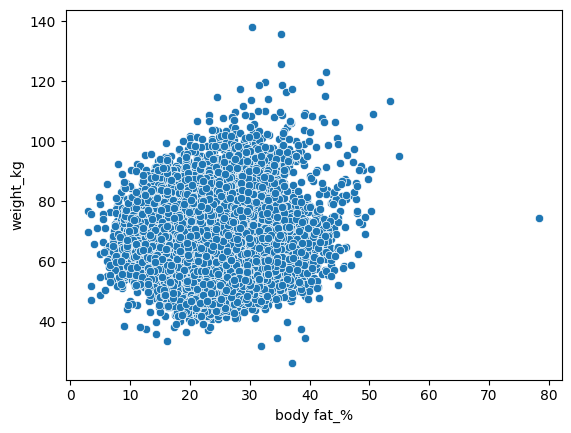

In [73]:
sns.scatterplot(DF, x="body fat_%", y="weight_kg");